### Import

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import os
caffe_root = '/Users/gijs/Various/caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe

from tqdm import tqdm
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray'

### Find and load Network

In [6]:
caffe.set_mode_cpu()
model_weights = '../../data/objectNet/Uganda/net/snapshot_iter_1700.caffemodel'
model_def = '../../data/objectNet/Uganda/net/deploy.prototxt'
net = caffe.Net(model_def,model_weights,caffe.TEST)

### Setup the net

In [7]:
#Load Actual Mean Image
meanimage = caffe.io.load_image('../../data/objectNet/Uganda/net/objectNet.jpg')
mymu = np.mean(meanimage,axis=0)
mymu = np.mean(mymu,axis=0) * 255
mymu = mymu[::-1]

#Create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  
transformer.set_mean('data', mymu)            
transformer.set_raw_scale('data', 255)      
transformer.set_channel_swap('data', (2,1,0))  

### Find the images

In [8]:
#Get Image List
filelist = []
cats = []
for root, dirs, files in os.walk("../../data/objectNet/Uganda/val/", topdown=False):
    elements = root.split('/')
    category = elements[-1]
    for m,myfile in enumerate(files):
        if (m < 200):
            filename = root + '/' + myfile
            cats.append(category)
            filelist.append(filename)

### Classify

In [35]:
#Pick Random Image
X = []
nIm = len(filelist)
mylabels = []
usedfiles = []
net.blobs['data'].reshape(nIm,3,227,227)
for i in tqdm(range(nIm)):

    #Hand over data to network
    image = caffe.io.load_image(filelist[i])
    usedfiles.append(filelist[i])
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[i,:,:,:] = transformed_image
    mylabels.append(cats[i])

#Run network
output = net.forward()

#Output
#ac = output['softmax'][:]
ac = net.blobs['fc8'].data
N = ac

In [36]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
X = model.fit_transform(N)

In [37]:
unique = list(set(mylabels))
c = np.random.random((len(unique),3))
C = []
for i in range(len(mylabels)):
    label = mylabels[i]
    index = unique.index(label)
    C.append(c[index,:])
C = np.array(C)

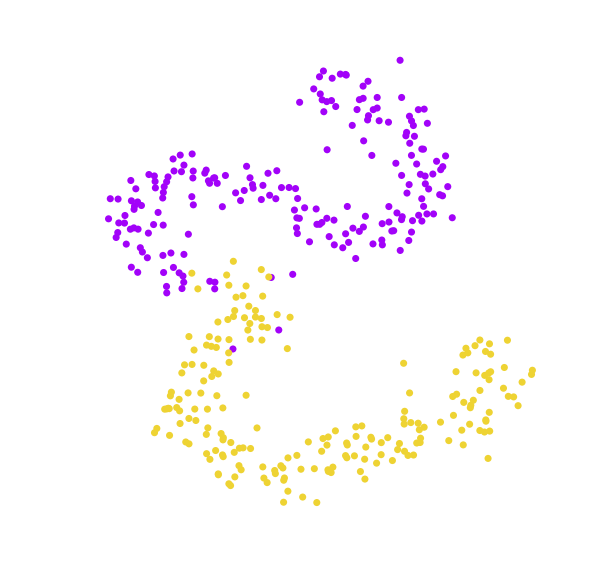

In [38]:
plt.scatter(X[:,0],X[:,1],c=C,linewidth=0,s=50);
plt.axis('off');

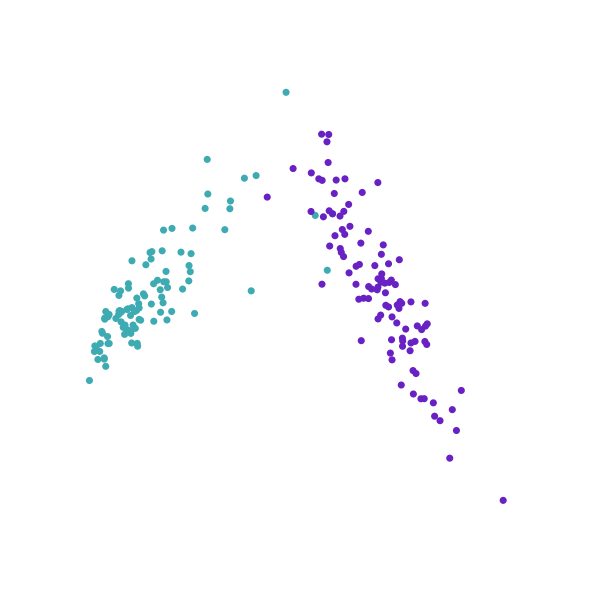

In [27]:
pca = PCA(n_components=2)
S = pca.fit_transform(N);
plt.scatter(S[:,0],S[:,1],c=C,linewidth=0,s=50);
plt.axis('off');

### Visualize

In [28]:
def visSquare(data):

    #Normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    #Force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 
               + ((0, 0),) * (data.ndim - 3))  
    data = np.pad(data, padding, mode='constant', constant_values=1)  
    
    #Tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data); plt.axis('off')

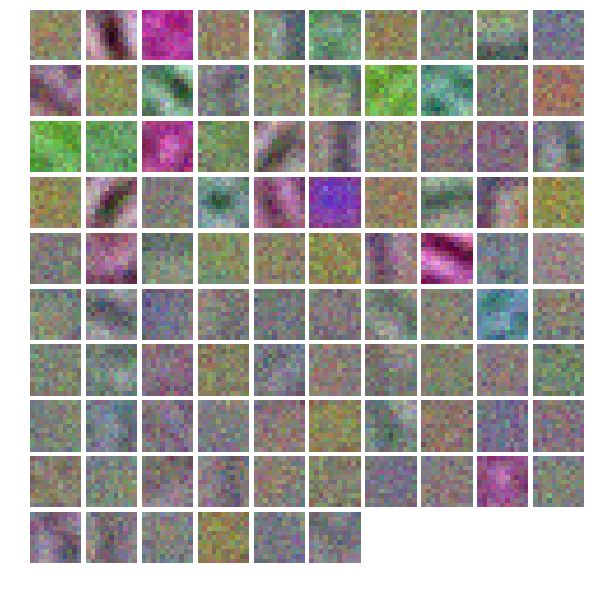

In [29]:
#The parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
visSquare(filters.transpose(0, 2, 3, 1))

(200, 2)
(100, 2)


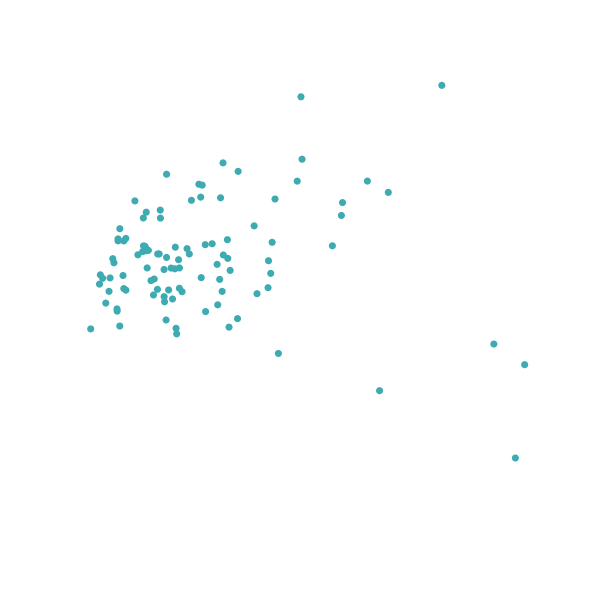

In [30]:
n = N.shape[0]
X = N[:n/2,:]
print N.shape
print X.shape
pca = PCA(n_components=2)
S = pca.fit_transform(X);
plt.scatter(S[:,0],S[:,1],c=C,linewidth=0,s=50);
plt.axis('off');

In [31]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
S = model.fit_transform(X)

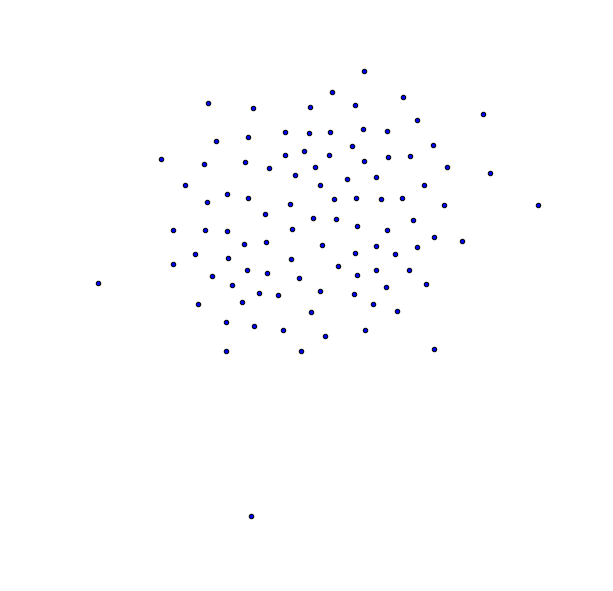

In [32]:
plt.scatter(S[:,0],S[:,1]);
plt.axis('off');